In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb

import shap

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.base import clone

from processing_functions import *

In [2]:
pd.set_option('display.max_colwidth', None)
df = pd.read_csv('data/input_file.csv')
#nan_percentage(df) 

There is a lot of data missing for how people think others perceive them, and what attributes they think the rest of their sex prefer. 

Since I am also going to be working with no gender, I will drop any column related to the binary separation of gender.

The attribute that overall has the most amount of missing data is 'shared interests'. I was hoping to use this attribute as a reliable feature to find partners, but based on the findings made in the EDA it is the feature that is the least important. 

In [3]:
def drop_columns(df, suffix):
    cols = [col for col in df.columns if any(col.endswith(s) for s in suffix)]
    
    df = df.drop(columns=cols, errors='ignore')
    
    return df
    

suffix= ['_fellow_want', 'perceived', '_o_want', '_diff']
df = drop_columns(df, suffix)
df_final = df.drop(columns=['Unnamed: 0'])
df_pred = df_final.copy(deep=True)

Since there are too many people and waves in this experiment, I am going to opt to drop the rows that have nan values so that it is easier to work with when it comes to training the dataset (especially with Random Forest). 

In [4]:
df_final.head()

,iid,id,wave,partner,pid,match,int_corr,age_o,pf_o_att,pf_o_sin,...,amb_self,dec,attr,sinc,intel,fun,amb,shar,like,prob
0,1,1.0,1,1,11.0,0,0.14,27.0,35.0,20.0,...,7.0,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0
1,1,1.0,1,2,12.0,0,0.54,22.0,60.0,0.0,...,7.0,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0
2,1,1.0,1,3,13.0,1,0.16,22.0,19.0,18.0,...,7.0,1,5.0,8.0,9.0,8.0,5.0,7.0,7.0,NaN
3,1,1.0,1,4,14.0,1,0.61,23.0,30.0,5.0,...,7.0,1,7.0,6.0,8.0,7.0,6.0,8.0,7.0,6.0
4,1,1.0,1,5,15.0,1,0.21,24.0,30.0,10.0,...,7.0,1,5.0,6.0,7.0,7.0,6.0,6.0,6.0,6.0


In [5]:
df_final = df_final.dropna()
print(df_final.columns)

Index(['iid', 'id', 'wave', 'partner', 'pid', 'match', 'int_corr', 'age_o',
       'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
       'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o',
       'like_o', 'prob_o', 'age', 'imprelig', 'goal', 'date', 'go_out',
       'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking',
       'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts',
       'music', 'shopping', 'yoga', 'exphappy', 'expnum', 'attr_important',
       'sinc_important', 'intel_important', 'fun_important', 'amb_important',
       'shar_important', 'attr_self', 'sinc_self', 'fun_self', 'intel_self',
       'amb_self', 'dec', 'attr', 'sinc', 'intel', 'fun', 'amb', 'shar',
       'like', 'prob'],
      dtype='object')


In [6]:
# Dropping identifier columns and irrelevant features for prediction
df = df_final.drop(columns=['iid', 'id', 'pid', 'partner', 'wave'], axis=1)

In [7]:
df.head()

,match,int_corr,age_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,...,amb_self,dec,attr,sinc,intel,fun,amb,shar,like,prob
0,0,0.14,27.0,35.0,20.0,20.0,20.0,0.0,5.0,0,...,7.0,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0
1,0,0.54,22.0,60.0,0.0,0.0,40.0,0.0,0.0,0,...,7.0,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0
3,1,0.61,23.0,30.0,5.0,15.0,40.0,5.0,5.0,1,...,7.0,1,7.0,6.0,8.0,7.0,6.0,8.0,7.0,6.0
4,1,0.21,24.0,30.0,10.0,20.0,10.0,10.0,20.0,1,...,7.0,1,5.0,6.0,7.0,7.0,6.0,6.0,6.0,6.0
5,0,0.25,25.0,50.0,0.0,30.0,10.0,0.0,10.0,1,...,7.0,0,4.0,9.0,7.0,4.0,6.0,4.0,6.0,5.0


In [8]:
X = df.drop(['match', 'dec', 'dec_o'], axis=1)
y = df['match']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [9]:
# Start by modelling a LightGBM and Random Forest model 
# Will do comparison of both and decide based on 
# maybe can try to use LightGBM but using 'random forest' as the boosting_type(?)

lgb_model = lgb.LGBMClassifier(random_state=42, verbose=-1)
rf_model = RandomForestClassifier(random_state=42)
xgb_model = xgb.XGBClassifier(random_state=42)

lgb_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [10]:
rf_accuracy = cross_val_score(rf_model, X_train, y_train, cv=5)
lgb_accuracy = cross_val_score(lgb_model, X_train, y_train, cv=5)
xgb_accuracy = cross_val_score(xgb_model, X_train, y_train, cv=5)

print("Random Forest Accuracy: ", rf_accuracy.mean())
print("LightGBM Accuracy: ", lgb_accuracy.mean())
print("XGBClassifier Accuracy: ", xgb_accuracy.mean())

Random Forest Accuracy:  0.8533333333333333
LightGBM Accuracy:  0.8573333333333333
XGBClassifier Accuracy:  0.844


In [11]:
# Comparison between models with classification_report
# Make prediction on the testing data
y_pred_rf = rf_model.predict(X_test)
y_pred_lgb = lgb_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

# Classification Report
print("RandomForestClassifier:\n", classification_report(y_test, y_pred_rf, zero_division=0))
print("LightGBM:\n", classification_report(y_pred_lgb, y_test))
print("XGBClassifer:\n", classification_report(y_pred_xgb, y_test))

print("\n")

# F1 Score
print("RandomForestClassifier F1 score:\n", f1_score(y_test, y_pred_rf, zero_division=0, average="weighted"),"\n")
print("LightGBM F1 score:\n", f1_score(y_pred_lgb, y_test, average="weighted"),"\n")
print("XGBClassifer F1 score:\n", f1_score(y_pred_xgb, y_test, average="weighted"))

RandomForestClassifier:
               precision    recall  f1-score   support

           0       0.88      0.98      0.92       208
           1       0.75      0.35      0.48        43

    accuracy                           0.87       251
   macro avg       0.81      0.66      0.70       251
weighted avg       0.86      0.87      0.85       251

LightGBM:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92       213
           1       0.56      0.63      0.59        38

    accuracy                           0.87       251
   macro avg       0.75      0.77      0.76       251
weighted avg       0.88      0.87      0.87       251

XGBClassifer:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93       217
           1       0.56      0.71      0.62        34

    accuracy                           0.88       251
   macro avg       0.76      0.81      0.78       251
weighted avg       0.90

In [12]:
df['match'].value_counts(normalize=True)

0    0.800319
1    0.199681
Name: match, dtype: float64

After looking at the accuracy and the other metrics we can see that, same as had previously measured in the EDA, this is a very unbalanced dataset. Almost 80% of the values belong to 0, while only 20% is part of the positive results.

There is a much higher number of 0s (no matches) than 1s (matches), there this makes the precision, accuracy and recall of the matches much more lower than the no matches.

We need to find a weight balance in order to work with it and in return choose the most appropriate model to work with.
References found in: [https://stackoverflow.com/questions/51190809/high-auc-but-bad-predictions-with-imbalanced-data]

We might also want to look into the performance of a =XGBoost= model since it performs better for unbalanced data. 
The boosting algorithm iteratively learns from the mistakes of the previous tree. So if a tree fails to predict a class (most likely the imbalanced class), the proceeding tree will give more weightage to this sample.

In [13]:
def pr_threshold(model, model_name='Model'):
    """
    Calculate and plot the precision-recall curve for a given model and test data.
    Also, find the threshold that yields the highest F1 score using an iterative method and plot the classification report based on this threshold.

    Returns:
    optimal_threshold: The threshold value that yields the highest F1 score.
    optimal_report: Classification report using the optimal threshold.
    """
    # probabilities for the positive class
    probabilities = model.predict_proba(X_val)[:,1]

    # precision, recall, and thresholds using the predicted probabilities
    precision, recall, thresholds = precision_recall_curve(y_val, probabilities)

    # F1 score for each threshold with tiny constant to avoid division by zero
    fscore = (2 * precision * recall) / (precision + recall + 1e-12)

    # Find the index of the maximum F1 score
    optimal_index = np.argmax(fscore)
    best_threshold = thresholds[optimal_index]

    # Make final predictions using the optimal threshold
    final_predictions = (model.predict_proba(X_test)[:,1] >= best_threshold).astype(int)

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
    plt.plot(thresholds, (2 * precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-12), 'r-.', label='F1 Score')
    plt.axvline(x=best_threshold, color='k', linestyle='--', label='Optimal Threshold')
    plt.xlabel('Threshold')
    plt.legend(loc='best')
    plt.ylim([0, 1])
    plt.title(f'{model_name}: Precision, Recall, and F1 Score for different thresholds')
    plt.show()

    optimal_report = classification_report(y_test, final_predictions, zero_division=0)
    return best_threshold, optimal_report

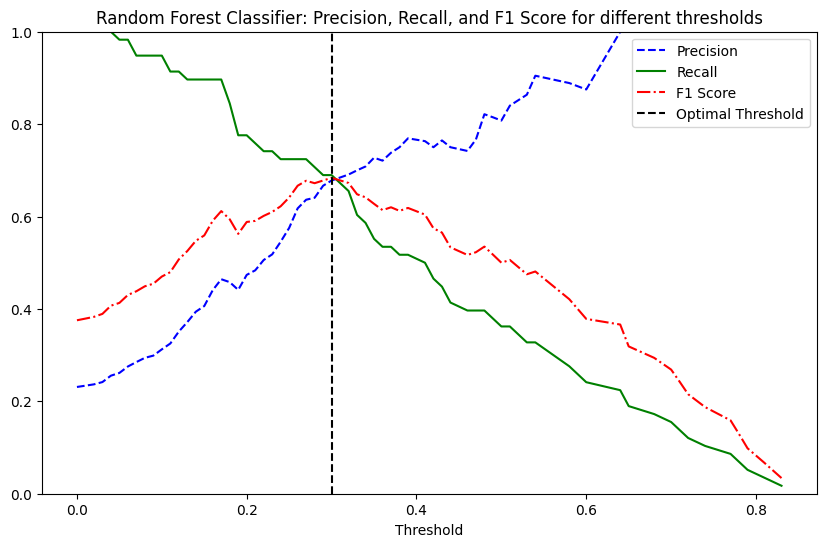

Optimal threshold for maximum Random Forest F1-score: 0.3
Using threshold ~0.3000 for evaluation.

              precision    recall  f1-score   support

           0       0.93      0.84      0.88       208
           1       0.47      0.67      0.55        43

    accuracy                           0.81       251
   macro avg       0.70      0.76      0.72       251
weighted avg       0.85      0.81      0.83       251
 

Random Forest: f1 score 0.8890810551048869


In [14]:
optimal_threshold_rf, optimal_report_rf = pr_threshold(rf_model, model_name='Random Forest Classifier')

print("Optimal threshold for maximum Random Forest F1-score:", optimal_threshold_rf)
print(f"Using threshold ~{optimal_threshold_rf:.4f} for evaluation.\n")
print(optimal_report_rf, "\n")

final_predictions_rf = (rf_model.predict(X_test) >= 0.3).astype(int)
print("Random Forest: f1 score", f1_score(final_predictions_rf, y_test, average="weighted"))

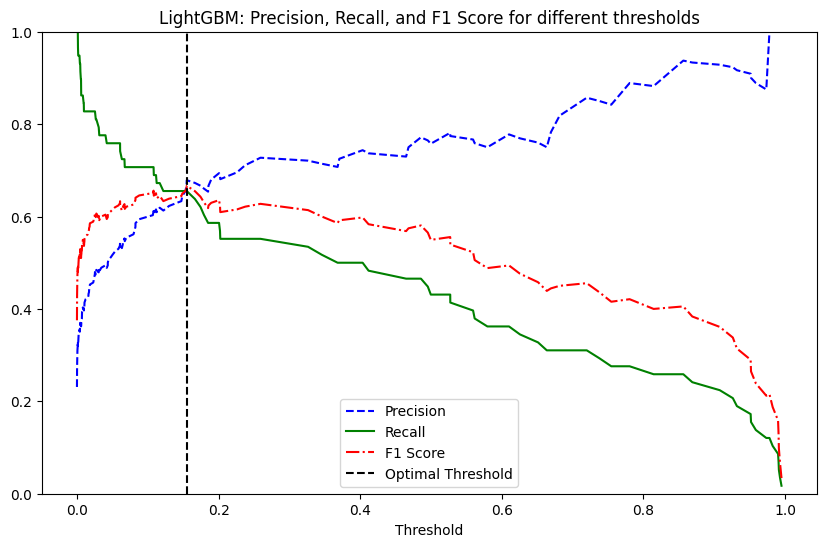

Optimal threshold for maximum LightGBM F1-score: 0.155051421246994
Using threshold ~0.1551 for evaluation.

              precision    recall  f1-score   support

           0       0.92      0.85      0.88       208
           1       0.46      0.63      0.53        43

    accuracy                           0.81       251
   macro avg       0.69      0.74      0.70       251
weighted avg       0.84      0.81      0.82       251

LightGBM: F1 score 0.871803014036929


In [15]:
optimal_threshold_lgb, optimal_report_lgb = pr_threshold(lgb_model, model_name='LightGBM')

print("Optimal threshold for maximum LightGBM F1-score:", optimal_threshold_lgb)
print(f"Using threshold ~{optimal_threshold_lgb:.4f} for evaluation.\n")
print(optimal_report_lgb)

final_predictions_lgb = (lgb_model.predict(X_test) >= optimal_threshold_lgb).astype(int)
print("LightGBM: F1 score", f1_score(final_predictions_lgb, y_test, average="weighted"))

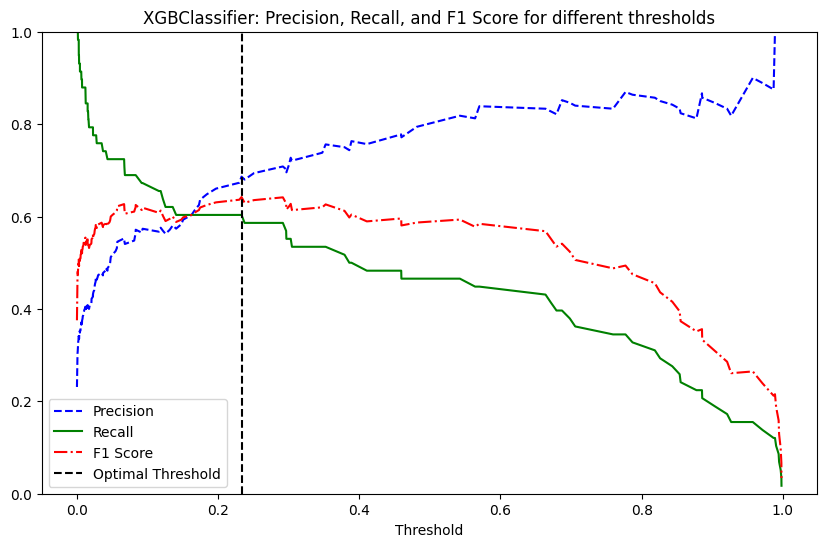

Optimal threshold for maximum XGBClassifier F1-score: 0.23315626
Using threshold ~0.2332 for evaluation.

              precision    recall  f1-score   support

           0       0.92      0.87      0.89       208
           1       0.49      0.63      0.55        43

    accuracy                           0.82       251
   macro avg       0.70      0.75      0.72       251
weighted avg       0.85      0.82      0.83       251

XGBClassifier: F1 score 0.889991021399505


In [16]:
optimal_threshold_xgb, optimal_report_xgb = pr_threshold(xgb_model, model_name='XGBClassifier')

print("Optimal threshold for maximum XGBClassifier F1-score:", optimal_threshold_xgb)
print(f"Using threshold ~{optimal_threshold_xgb:.4f} for evaluation.\n")
print(optimal_report_xgb)

final_predictions_xgb = (xgb_model.predict(X_test) >= optimal_threshold_xgb).astype(int)
print("XGBClassifier: F1 score", f1_score(final_predictions_xgb, y_test, average="weighted"))

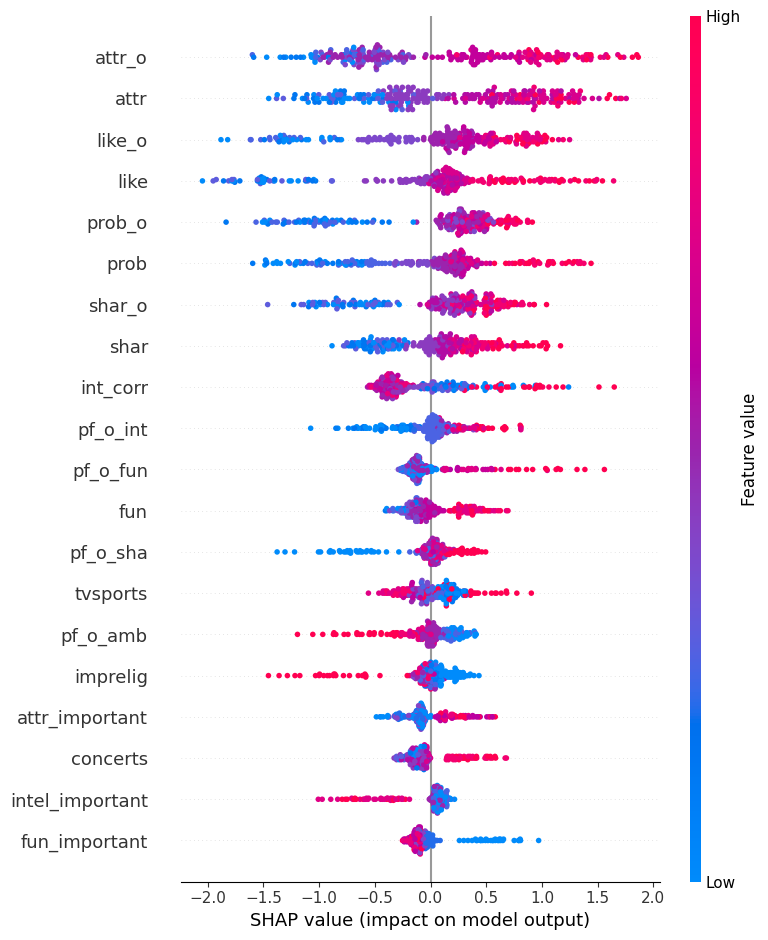

In [17]:
explainer = shap.Explainer(lgb_model, X_train)
shap_values_lgb = explainer.shap_values(X_test)

# Visualize the SHAP values
shap.summary_plot(shap_values_lgb, X_test)

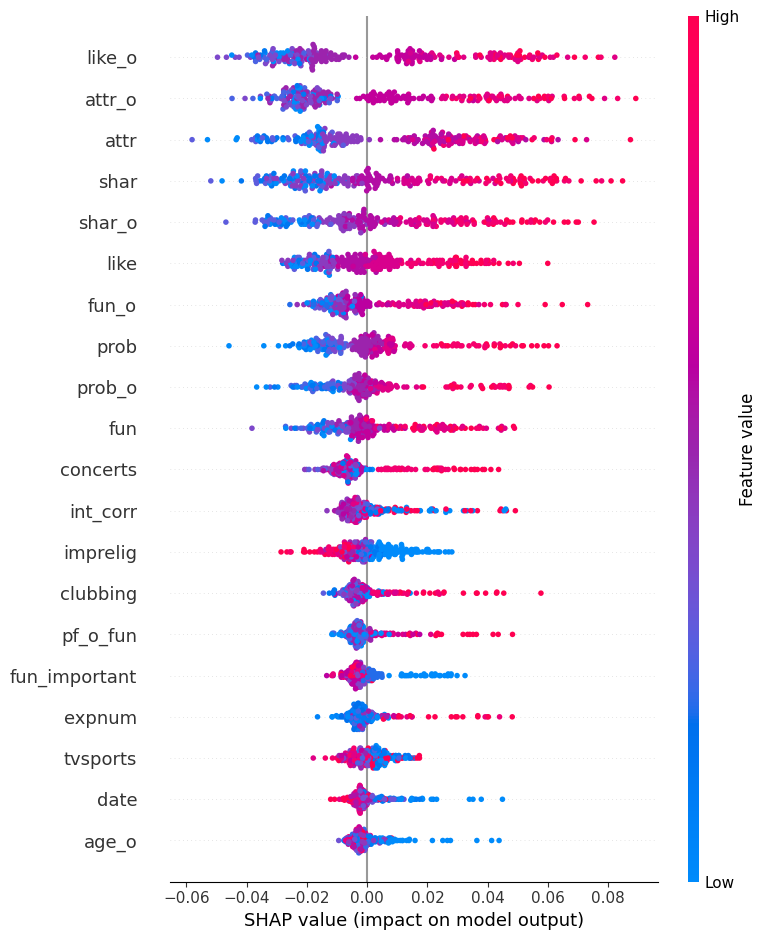

In [18]:
explainer = shap.Explainer(rf_model, X_train)
shap_values_rf = explainer.shap_values(X_test, check_additivity=False)

# Visualize the SHAP values
shap.summary_plot(shap_values_rf[1], X_test)

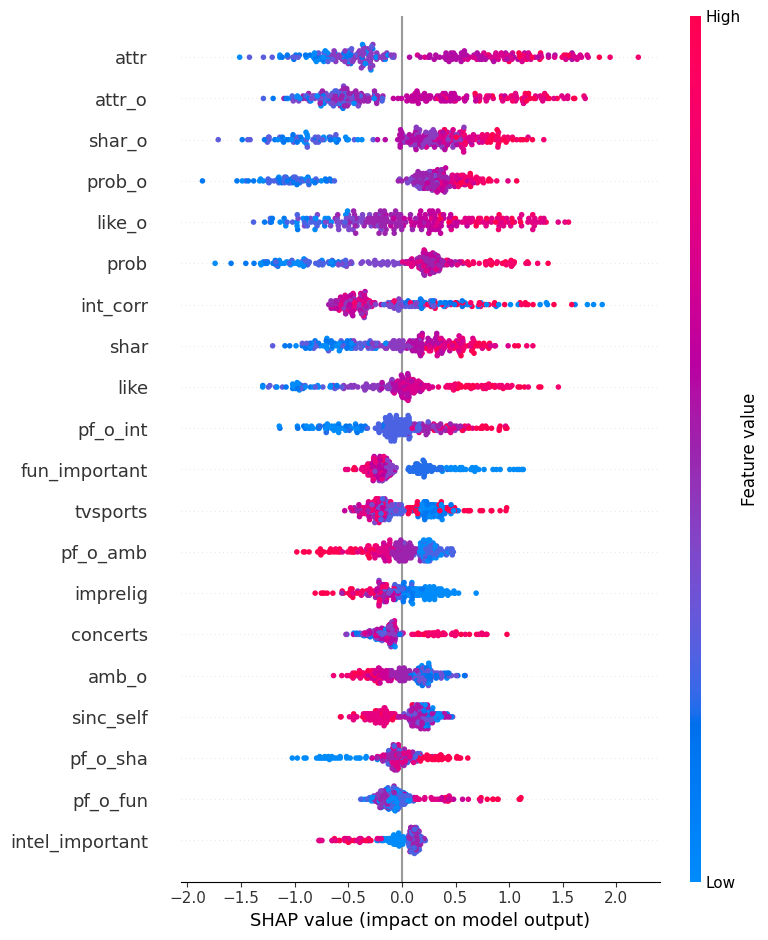

In [19]:
explainer = shap.Explainer(xgb_model, X_train)
shap_values_xgb = explainer.shap_values(X_test)

# Visualize the SHAP values
shap.summary_plot(shap_values_xgb, X_test)

In [20]:
def shap_importance(model, shap_values):
    """
    Return a dataframe containing the features sorted by Shap importance.

    Parameters:
    model : The tree-based model (like RandomForest, XGBoost, etc.).

    Returns:
    pd.DataFrame
        A dataframe containing the features sorted by Shap importance.
    """
    # explainer = shap.Explainer(model, X_train)
    
    # shap_values = explainer.shap_values(X_test, check_additivity=False)
    
    if isinstance(shap_values, list):
        shap_values = np.abs(shap_values[1])
    else:
        shap_values = np.abs(shap_values)
        
    mean_abs_shap_values = shap_values.mean(axis=0)
    
    feature_importance = pd.DataFrame({
        'features': X_test.columns,
        'importance': mean_abs_shap_values
    })
    
    feature_importance.sort_values(by='importance', ascending=False, inplace=True)
    return feature_importance.reset_index(drop=True).head(30)

top_features = shap_importance(xgb_model, shap_values_rf).drop([0, 26, 19, 11, 5, 16])

In [21]:
top_features

,features,importance
1,attr_o,0.025604
2,attr,0.025145
3,shar,0.024328
4,shar_o,0.020584
6,fun_o,0.013630
7,prob,0.013470
8,prob_o,0.011792
9,fun,0.011731
10,concerts,0.009877
12,imprelig,0.007588


In [22]:
print(df_final['iid'].unique())
df_final.to_csv('data/clean_data.csv')

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  29  30  31  32  33  34  35  36  37
  38  39  40  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 115 116 117 119 120 121 122 123 124 125 126 127 128 130 131]


In [23]:
df_final[df_final['wave'] == 1]

,iid,id,wave,partner,pid,match,int_corr,age_o,pf_o_att,pf_o_sin,...,amb_self,dec,attr,sinc,intel,fun,amb,shar,like,prob
0,1,1.0,1,1,11.0,0,0.14,27.0,35.00,20.00,...,7.0,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0
1,1,1.0,1,2,12.0,0,0.54,22.0,60.00,0.00,...,7.0,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0
3,1,1.0,1,4,14.0,1,0.61,23.0,30.00,5.00,...,7.0,1,7.0,6.0,8.0,7.0,6.0,8.0,7.0,6.0
4,1,1.0,1,5,15.0,1,0.21,24.0,30.00,10.00,...,7.0,1,5.0,6.0,7.0,7.0,6.0,6.0,6.0,6.0
5,1,1.0,1,6,16.0,0,0.25,25.0,50.00,0.00,...,7.0,0,4.0,9.0,7.0,4.0,6.0,4.0,6.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,20,10.0,1,6,6.0,0,0.43,23.0,10.00,25.00,...,10.0,0,7.0,10.0,10.0,6.0,10.0,7.0,6.0,7.0
196,20,10.0,1,7,7.0,0,-0.16,22.0,15.00,15.00,...,10.0,0,7.0,6.0,8.0,6.0,8.0,7.0,7.0,7.0
197,20,10.0,1,8,8.0,1,-0.21,25.0,9.09,18.18,...,10.0,1,8.0,10.0,9.0,9.0,8.0,8.0,8.0,8.0
198,20,10.0,1,9,9.0,0,-0.23,26.0,20.00,10.00,...,10.0,0,5.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0


In [24]:
def wave_matches_display(df):
    # Dictionary to store data for each wave
    wave_data = {}

    # Group by wave and process each group
    for wave, group in df.groupby('wave'):
        # Collect all participants in the wave
        participants = list(group['iid'].unique())
        
        # Collect matches as lists of pairs
        matches = []
        for index, person in group.iterrows():
            if person['match'] == 1 and person['pid'] in group['iid'].values:
                matches.append([person['iid'], person['pid']])
        
        # Storing results in the dictionary with wave as key
        wave_data[wave] = {
            "participants": participants,
            "matches": matches
        }

    # Convert the dictionary into a DataFrame
    wave_df = pd.DataFrame([
        {'wave': wave, 'participants': data['participants'], 'matches': data['matches']}
        for wave, data in wave_data.items()
    ])

    return wave_df

wave_df = wave_matches_display(df_final)
wave_df_pred = wave_matches_display(df_pred)

In [25]:
wave_df

,wave,participants,matches
0,1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]","[[1.0, 14.0], [1.0, 15.0], [1.0, 19.0], [2.0, 14.0], [2.0, 19.0], [4.0, 14.0], [4.0, 19.0], [5.0, 14.0], [5.0, 19.0], [6.0, 14.0], [6.0, 19.0], [7.0, 14.0], [7.0, 19.0], [8.0, 12.0], [8.0, 13.0], [8.0, 14.0], [8.0, 16.0], [8.0, 18.0], [8.0, 19.0], [8.0, 20.0], [9.0, 12.0], [9.0, 13.0], [9.0, 14.0], [9.0, 15.0], [9.0, 16.0], [9.0, 17.0], [9.0, 19.0], [10.0, 19.0], [12.0, 8.0], [12.0, 9.0], [13.0, 8.0], [13.0, 9.0], [14.0, 1.0], [14.0, 2.0], [14.0, 4.0], [14.0, 5.0], [14.0, 6.0], [14.0, 7.0], [14.0, 8.0], [14.0, 9.0], [15.0, 1.0], [15.0, 9.0], [16.0, 8.0], [16.0, 9.0], [17.0, 9.0], [18.0, 8.0], [19.0, 1.0], [19.0, 2.0], [19.0, 4.0], [19.0, 5.0], [19.0, 6.0], [19.0, 7.0], [19.0, 8.0], [19.0, 9.0], [19.0, 10.0], [20.0, 8.0]]"
1,2,"[21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]","[[22.0, 44.0], [22.0, 45.0], [23.0, 43.0], [23.0, 44.0], [23.0, 45.0], [27.0, 46.0], [29.0, 44.0], [29.0, 45.0], [30.0, 55.0], [31.0, 55.0], [34.0, 49.0], [35.0, 45.0], [35.0, 46.0], [35.0, 49.0], [35.0, 53.0], [36.0, 49.0], [36.0, 51.0], [37.0, 44.0], [37.0, 52.0], [38.0, 49.0], [38.0, 55.0], [39.0, 47.0], [43.0, 23.0], [44.0, 22.0], [44.0, 23.0], [44.0, 29.0], [44.0, 37.0], [45.0, 22.0], [45.0, 23.0], [45.0, 29.0], [45.0, 35.0], [46.0, 27.0], [46.0, 35.0], [47.0, 39.0], [49.0, 34.0], [49.0, 35.0], [49.0, 36.0], [49.0, 38.0], [51.0, 36.0], [52.0, 37.0], [53.0, 35.0], [55.0, 30.0], [55.0, 31.0], [55.0, 38.0]]"
2,3,"[56, 57, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]","[[56.0, 70.0], [57.0, 71.0], [61.0, 71.0], [61.0, 75.0], [62.0, 67.0], [62.0, 74.0], [63.0, 67.0], [64.0, 75.0], [67.0, 62.0], [67.0, 63.0], [70.0, 56.0], [71.0, 57.0], [71.0, 61.0], [74.0, 62.0], [75.0, 61.0], [75.0, 64.0]]"
3,4,"[76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111]","[[77.0, 94.0], [77.0, 97.0], [77.0, 99.0], [77.0, 105.0], [77.0, 107.0], [78.0, 107.0], [78.0, 109.0], [79.0, 107.0], [79.0, 108.0], [80.0, 102.0], [80.0, 105.0], [80.0, 109.0], [81.0, 99.0], [81.0, 104.0], [81.0, 108.0], [82.0, 94.0], [82.0, 99.0], [82.0, 105.0], [82.0, 107.0], [82.0, 109.0], [83.0, 99.0], [83.0, 107.0], [84.0, 105.0], [84.0, 108.0], [85.0, 107.0], [86.0, 97.0], [86.0, 100.0], [86.0, 104.0], [86.0, 105.0], [86.0, 107.0], [86.0, 108.0], [86.0, 109.0], [86.0, 110.0], [87.0, 99.0], [87.0, 107.0], [89.0, 99.0], [89.0, 104.0], [90.0, 109.0], [92.0, 97.0], [92.0, 99.0], [92.0, 105.0], [92.0, 107.0], [92.0, 109.0], [93.0, 95.0], [93.0, 100.0], [93.0, 104.0], [94.0, 77.0], [94.0, 82.0], [95.0, 93.0], [97.0, 77.0], [97.0, 86.0], [97.0, 92.0], [99.0, 77.0], [99.0, 81.0], [99.0, 82.0], [99.0, 83.0], [99.0, 87.0], [99.0, 89.0], [99.0, 92.0], [100.0, 86.0], [100.0, 93.0], [102.0, 80.0], [104.0, 81.0], [104.0, 86.0], [104.0, 89.0], [104.0, 93.0], [105.0, 77.0], [105.0, 80.0], [105.0, 82.0], [105.0, 84.0], [105.0, 86.0], [105.0, 92.0], [107.0, 77.0], [107.0, 78.0], [107.0, 79.0], [107.0, 82.0], [107.0, 83.0], [107.0, 85.0], [107.0, 86.0], [107.0, 87.0], [107.0, 92.0], [108.0, 79.0], [108.0, 81.0], [108.0, 84.0], [108.0, 86.0], [109.0, 78.0], [109.0, 80.0], [109.0, 82.0], [109.0, 86.0], [109.0, 90.0], [109.0, 92.0], [110.0, 86.0]]"
4,5,"[112, 113, 115, 116, 117, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 130, 131]","[[112.0, 122.0], [112.0, 125.0], [112.0, 126.0], [112.0, 127.0], [112.0, 128.0], [113.0, 125.0], [113.0, 126.0], [113.0, 128.0], [115.0, 125.0], [115.0, 127.0], [115.0, 128.0], [116.0, 122.0], [116.0, 125.0], [116.0, 127.0], [117.0, 125.0], [119.0, 125.0], [119.0, 127.0], [120.0, 122.0], [120.0, 125.0], [120.0, 128.0], [122.0, 112.0], [122.0, 116.0], [122.0, 120.0], [125.0, 112.0], [125.0, 113.0], [125.0, 115.0], [125.0, 116.0], [125.0, 117.0], [125.0, 119.0], [125.0, 120.0], [126.0, 

In [26]:
#wave_df_pred

In [27]:
def indices_column(df, value):
    filtered_df = df[df['wave'] == value]
    indices = filtered_df.index.tolist()
    return indices

# select rows from another dataframe using the obtained indices
def select_rows(df, indices):
    return df.iloc[indices]

indices = indices_column(df_final, 1)
df_wave = select_rows(df_final, indices)
df_wave = df_wave.drop(columns=['id', 'partner', 'wave', 'age_o', 'expnum'], axis=1)
# df_wave = df_wave.drop(df_wave[df_wave['iid'] == 21].index)
# df_wave = df_wave.drop(df_wave[df_wave['iid'] == 22].index)
#print(indices)

In [28]:
df_wave['like']

0      7.0
1      7.0
4      6.0
5      6.0
6      6.0
      ... 
222    7.0
227    2.0
228    2.0
229    8.0
230    4.0
Name: like, Length: 176, dtype: float64

In [29]:
shap_columns = top_features['features'].to_list()
shap_features = df_wave[shap_columns]
print(shap_features)

     attr_o  attr  shar  shar_o  fun_o  prob  prob_o  fun  concerts  imprelig  \
0       6.0   6.0   5.0     6.0    8.0   6.0     4.0  7.0      10.0       4.0   
1       7.0   7.0   6.0     5.0    7.0   5.0     4.0  8.0      10.0       4.0   
4       8.0   5.0   6.0     7.0    6.0   6.0     6.0  7.0      10.0       4.0   
5       7.0   4.0   4.0     7.0    8.0   5.0     6.0  4.0      10.0       4.0   
6       3.0   7.0   7.0     7.0    5.0   5.0     1.0  4.0      10.0       4.0   
..      ...   ...   ...     ...    ...   ...     ...  ...       ...       ...   
222     5.0   8.0   7.0     5.0    5.0   4.0     5.0  7.0       7.0       2.0   
227     2.0   3.0   2.0     1.0    2.0   1.0     1.0  4.0       7.0       2.0   
228     4.0   3.0   4.0     5.0    6.0   2.0     2.0  5.0       7.0       2.0   
229     6.0   7.0   8.0     6.0    7.0   5.0     5.0  6.0       7.0       2.0   
230     4.0   4.0   4.0     5.0    6.0   2.0     4.0  4.0       7.0       2.0   

     ...  date  pf_o_att  t

In [30]:
attributes = [
    'iid', 
    'attr_o', 
    'sinc_o',
    'intel_o', 
    'fun_o', 
    'amb_o', 
    'shar_o',    
    # 'attr_self', 
    # 'sinc_self', 
    # 'intel_self', 
    # 'fun_self', 
    # 'amb_self'
]

attributes_averages = df_wave[attributes].groupby('iid').mean().reset_index()
print(attributes_averages)

# df_wave['goal'].value_counts()

    iid    attr_o    sinc_o   intel_o     fun_o     amb_o    shar_o
0     1  6.250000  7.000000  7.625000  6.750000  7.625000  6.625000
1     2  7.700000  7.100000  7.900000  7.500000  7.500000  6.500000
2     3  6.833333  7.166667  7.833333  6.333333  7.500000  6.166667
3     4  7.000000  7.100000  7.700000  7.500000  7.700000  7.200000
4     5  5.300000  7.700000  7.600000  7.200000  7.800000  6.200000
5     6  6.800000  7.800000  8.600000  7.000000  8.000000  6.300000
6     7  7.900000  7.600000  8.200000  7.000000  7.500000  6.700000
7     8  8.125000  7.750000  8.125000  7.500000  7.375000  6.375000
8     9  7.000000  7.400000  7.500000  7.800000  6.900000  6.300000
9    10  6.500000  6.500000  6.500000  6.500000  6.000000  6.000000
10   11  5.500000  8.000000  7.500000  5.500000  6.000000  4.000000
11   12  7.875000  7.125000  7.875000  7.250000  7.875000  6.125000
12   13  4.714286  7.857143  8.714286  6.285714  6.000000  5.857143
13   14  8.142857  7.428571  7.000000  7.285714 

This will all be put into a *Class* later to make it look prettier

In [31]:
def goal_mapping(df):
    # First, create a mapping dictionary for the 'goal' values
    mapping = {
        1: 1, 2: 1,
        3: 2, 4: 2,
        5: 3, 6: 3
    }

    # Aggregate the DataFrame by 'iid' and take the first 'goal' from each group
    aggregated_df = df.groupby('iid').agg({'goal': 'first'}).reset_index()

    # Apply the mapping to the 'goal' column and create a new column for remapped values
    aggregated_df['goal'] = aggregated_df['goal'].map(mapping).fillna(aggregated_df['goal'])

    return aggregated_df

goals = goal_mapping(df_wave)
attributes_averages = pd.concat([attributes_averages, goals['goal']], axis=1)
attributes_averages.head()

,iid,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,goal
0,1,6.250000,7.000000,7.625000,6.750000,7.625,6.625000,1
1,2,7.700000,7.100000,7.900000,7.500000,7.500,6.500000,1
2,3,6.833333,7.166667,7.833333,6.333333,7.500,6.166667,3
3,4,7.000000,7.100000,7.700000,7.500000,7.700,7.200000,1
4,5,5.300000,7.700000,7.600000,7.200000,7.800,6.200000,1


In [32]:
importance = df_wave[[
    'iid',
    'attr_important', 
    'sinc_important', 
    'intel_important',
    'fun_important', 
    'amb_important', 
    'shar_important'
]]

importance = importance.groupby('iid').mean().round().astype(int)
importance = importance.apply(lambda x: np.clip(x, 1, 6))

def resolve_conflicts(row):
    # Sort row values and get indices of the sorted elements
    sorted_indices = np.argsort(row)
    ranks = np.arange(1, 7)

    # Assign ranks according to the sorted indices (smallest value gets rank 1, largest gets rank N)
    sorted_row = np.empty_like(ranks)
    sorted_row[sorted_indices] = ranks

    return pd.Series(sorted_row, index=row.index)

importance_attributes = importance.apply(resolve_conflicts, axis=1).reset_index()
importance_attributes = pd.concat([importance_attributes, goals['goal']], axis=1)
importance_attributes

,iid,attr_important,sinc_important,intel_important,fun_important,amb_important,shar_important,goal
0,1,5,2,1,3,6,4,1
1,2,1,4,2,3,6,5,1
2,3,1,3,2,4,5,6,3
3,4,3,1,2,4,5,6,1
4,5,3,6,2,1,5,4,1
5,6,5,2,3,1,6,4,1
6,7,3,4,1,2,5,6,1
7,8,5,2,1,3,4,6,1
8,9,2,4,3,1,5,6,1
9,10,4,2,3,1,5,6,1


In [33]:
date_rankings = df_wave[['iid', 'pid', 'attr', 'sinc', 'intel', 'fun', 'amb', 'shar']]
shared = df_wave[[
    'iid',
    'sports', 
    'tvsports', 
    'exercise', 
    'dining', 
    'museums', 
    'art', 
    'hiking', 
    'gaming', 
    'clubbing', 
    'reading', 
    'tv', 
    'theater', 
    'movies', 
    'concerts', 
    'music', 
    'shopping', 
    'yoga'
]].drop_duplicates()

In [49]:
X_class = df_wave.drop(columns=['match', 'iid', 'pid'])
y_class = df_wave['match']

X_reg = df_wave.drop(columns=['like', 'iid', 'pid', 'like_o'])
y_reg = df_wave['like']

# Define a K-Fold cross-validator
kf = KFold(n_splits=3, shuffle=True, random_state=42) 

param_grid = {
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search_xgb_classifier = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=kf, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search_xgb_regressor = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)


# Fit GridSearchCV
grid_search_xgb_classifier.fit(X_class, y_class)
grid_search_xgb_regressor.fit(X_reg, y_reg)

print("Best parameters found xgb_classifier: ", grid_search_xgb_classifier.best_params_)
print("Best parameters found xgb_regressor: ", grid_search_xgb_regressor.best_params_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=1; total time=   0.1s
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=1; total time=   0.2s
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=10, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=10, n_estimators=50, subsample=1; total time=   0.2s
[CV] END colsample_bytree=1, learning_rate=

In [50]:
X = df_wave.drop(columns=['match', 'iid', 'pid'])
y = df_wave['match']

kf = KFold(n_splits=3, shuffle=True, random_state=42)

classifier = xgb.XGBClassifier(
    n_estimators=50,
    learning_rate=0.01,
    max_depth=3,
    objective='binary:logistic',
    use_label_encoder=False,  
    # eval_metric='logloss',    # Metric used for classification
    random_state=42,
    subsample=0.8,
    colsample_bytree=0.8
)

y_pred = cross_val_predict(classifier, X, y, cv=kf)

results_df = pd.DataFrame({
    'iid': df_wave['iid'],
    'pid': df_wave['pid'],
    'predicted_match': y_pred,
    'actual_match': y
})

df_wave['match_predictions'] = results_df['predicted_match']
attributes_averages['match_predictions'] = results_df['predicted_match']

In [51]:
df_wave.columns
attributes_averages.columns

Index(['iid', 'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o',
       'goal', 'match_predictions'],
      dtype='object')

In [52]:
def individual_preference(attributes_averages, importance, iid, date_rankings, df_wave):
    """
    Computes and ranks potential partners for a specified individual based on their preference weights, matching dating goals,
    individual rankings given during past dates, common interests, and the significance of those goals.
    
    Args:
    - attributes_averages (DataFrame): DataFrame containing averaged attributes and dating goals for each person.
    - importance (DataFrame): DataFrame containing the importance rankings for each attribute and dating goals for each person.
    - iid (int): The individual ID for whom to compute the scores.
    - date_rankings (DataFrame): DataFrame containing the rankings given by subjects to their dates across various attributes.
    - df_wave (DataFrame): DataFrame containing ratings for various activities and interests from 1 to 10.
    
    Returns:
    - DataFrame: A DataFrame of other persons ranked by compatibility for the specified individual.
    """
    if iid not in importance['iid'].values:
        return "Invalid iid. This individual does not exist in the importance dataset."

    # importance rankings and dating goal for the specified individual
    person_importance = importance.loc[importance['iid'] == iid].iloc[0]
    person_goal = person_importance['goal']

    # adjust importance rankings (now 6 most important, 1 least important) to be used as weights
    for attr in person_importance.index:
        if 'important' in attr:
            person_importance[attr] = 7 - person_importance[attr]

    # merging the date rankings for the iid into attributes_averages
    relevant_rankings = date_rankings[date_rankings['iid'] == iid]
    if not relevant_rankings.empty:
        relevant_rankings = relevant_rankings.set_index('pid')
        attributes_averages = attributes_averages.join(relevant_rankings, on='iid', how='left', rsuffix='_ranked')

    # Set up the wave data for interests calculation
    df_wave = df_wave.set_index('iid')
    #print(df_wave)
    subject_interests = df_wave.loc[iid]
    partner_interests = df_wave.loc[relevant_rankings.index]

    # Calculate common interests
    common_interests_columns = ['sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 
                                'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga']
    common_interests_score = (partner_interests[common_interests_columns] >= 8) & (subject_interests[common_interests_columns] >= 8)
    common_interests_score = common_interests_score.sum(axis=1) * 5

    scores_df = attributes_averages.copy()
    scores_df['total_score'] = 0

    # weighted scores for attributes and replace NaN values where necessary
    for important_attr in person_importance.index:
        if 'important' in important_attr:
            observed_attr = important_attr.replace('_important', '') + '_o'
            ranked_attr = observed_attr.replace('_o', '') + '_ranked'
            if observed_attr in scores_df.columns:
                weighted_score = scores_df[observed_attr] * person_importance[important_attr]
                scores_df['total_score'] += weighted_score
                #if there are already ranked scores, add them (replace NaNs with attribute averages)
                if ranked_attr in scores_df.columns:
                    scores_df[ranked_attr] = scores_df[ranked_attr].fillna(scores_df[observed_attr])
                    scores_df['total_score'] += scores_df[ranked_attr] * person_importance[important_attr]

    # Add common interests score from the correctly indexed partner interests
    scores_df.loc[partner_interests.index, 'total_score'] += common_interests_score.fillna(0)

    # Apply goal matching boost
    goal_boost = 10
    scores_df['total_score'] += (scores_df['goal'] == person_goal) * goal_boost

    match_bonus = 5
    scores_df['total_score'] += scores_df['match_predictions'].fillna(0) * match_bonus

    # Remove the individual from the DataFrame, sort by total_score
    scores_df = scores_df.drop(index=iid-1)
    scores_df.sort_values('total_score', ascending=False, inplace=True)
    preference_list = scores_df['iid'].tolist()

    return preference_list

iids = range(1, 21)
for iid in iids:
    preference_list = individual_preference(attributes_averages, importance_attributes, iid, date_rankings, shared)
    print(f"Preference list for iid {iid}:\n{preference_list}\n")

Preference list for iid 1:
[20, 13, 12, 19, 8, 6, 14, 7, 9, 17, 2, 4, 5, 18, 21, 16, 15, 3, 11, 10, 22]

Preference list for iid 2:
[14, 20, 12, 19, 8, 7, 17, 9, 15, 6, 4, 21, 13, 5, 1, 16, 3, 18, 10, 11, 22]

Preference list for iid 3:
[14, 8, 7, 19, 20, 12, 6, 2, 9, 21, 17, 4, 5, 1, 15, 13, 18, 11, 10, 16, 22]

Preference list for iid 4:
[14, 20, 8, 7, 6, 9, 12, 2, 5, 19, 1, 17, 13, 11, 21, 16, 3, 15, 18, 10, 22]

Preference list for iid 5:
[14, 20, 19, 8, 9, 7, 2, 12, 4, 6, 1, 15, 17, 13, 3, 10, 18, 21, 11, 16, 22]

Preference list for iid 6:
[20, 14, 12, 8, 9, 15, 7, 13, 4, 2, 5, 19, 21, 17, 1, 18, 16, 3, 10, 11, 22]

Preference list for iid 7:
[14, 20, 12, 19, 21, 8, 6, 15, 9, 17, 2, 4, 13, 5, 1, 16, 18, 3, 10, 11, 22]

Preference list for iid 8:
[14, 21, 12, 19, 6, 20, 7, 9, 5, 2, 15, 17, 4, 13, 1, 18, 3, 11, 10, 16, 22]

Preference list for iid 9:
[14, 20, 12, 19, 8, 7, 2, 15, 6, 17, 4, 5, 13, 21, 1, 16, 18, 3, 10, 11, 22]

Preference list for iid 10:
[20, 8, 9, 14, 7, 6, 2, 12,

In [53]:
def cosine_pairs_similarity(df, pairs, features):
    """
    Calculate cosine similarity for specified pairs in the DataFrame.

    Arguments:
    - df (DataFrame): The DataFrame containing user features.
    - pairs (list of lists): A list containing sublists, each sublist is a pair of IDs [iid, pid].
    - features (list): A list of column names to use as features for calculating similarity.

    Returns:
    - DataFrame: A DataFrame with the pair identifiers and their similarity scores.
    """
    results = []

    # Standardize the features
    scaler = StandardScaler()
    df[features] = scaler.fit_transform(df[features])

    # Process each pair
    for pair in pairs:
        id1, id2 = pair
        # Extract features for both ids in the pair
        person1_features = df.loc[df['iid'] == id1, features].values
        person2_features = df.loc[df['iid'] == id2, features].values

        # Calculate cosine similarity
        if len(person1_features) > 0 and len(person2_features) > 0:  # Ensure both persons are in the dataset
            similarity_score = cosine_similarity(person1_features, person2_features)[0][0]
            results.append([id1, id2, similarity_score])

    # Convert results to DataFrame
    similarity_df = pd.DataFrame(results, columns=['iid', 'pid', 'similarity_score'])

    return similarity_df

features = ['age', 'imprelig', 'goal', 'date', 'go_out', 'sports', 'tvsports', 'exercise',
            'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading',
            'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga',
            'exphappy', 'attr_important', 'sinc_important', 'intel_important',
            'fun_important', 'amb_important', 'shar_important', 'like', 'like_o']
pairs = [[1.0, 14.0], [1.0, 15.0], [1.0, 19.0], [2.0, 14.0], [2.0, 19.0], [4.0, 14.0], [4.0, 19.0], [5.0, 14.0], [5.0, 19.0], [6.0, 14.0], [6.0, 19.0], [7.0, 14.0], [7.0, 19.0], [8.0, 12.0], [8.0, 13.0], [8.0, 14.0], [8.0, 16.0], [8.0, 18.0], [8.0, 19.0], [8.0, 20.0], [9.0, 12.0], [9.0, 13.0], [9.0, 14.0], [9.0, 15.0], [9.0, 16.0], [9.0, 17.0], [9.0, 19.0], [10.0, 19.0], [12.0, 8.0], [12.0, 9.0], [13.0, 8.0], [13.0, 9.0], [14.0, 1.0], [14.0, 2.0], [14.0, 4.0], [14.0, 5.0], [14.0, 6.0], [14.0, 7.0], [14.0, 8.0], [14.0, 9.0], [15.0, 1.0], [15.0, 9.0], [16.0, 8.0], [16.0, 9.0], [17.0, 9.0], [18.0, 8.0], [19.0, 1.0], [19.0, 2.0], [19.0, 4.0], [19.0, 5.0], [19.0, 6.0], [19.0, 7.0], [19.0, 8.0], [19.0, 9.0], [19.0, 10.0], [20.0, 8.0]]
similarity_results = cosine_pairs_similarity(df_wave, pairs, features)
print(similarity_results)

     iid   pid  similarity_score
0    1.0  14.0          0.249281
1    1.0  15.0          0.028956
2    1.0  19.0         -0.260150
3    2.0  14.0         -0.307446
4    2.0  19.0         -0.124389
5    4.0  14.0         -0.198492
6    4.0  19.0         -0.408897
7    5.0  14.0          0.315829
8    5.0  19.0          0.083783
9    6.0  14.0         -0.015855
10   6.0  19.0          0.031067
11   7.0  14.0         -0.225250
12   7.0  19.0         -0.244326
13   8.0  12.0         -0.306740
14   8.0  13.0         -0.039139
15   8.0  14.0         -0.283951
16   8.0  16.0         -0.265278
17   8.0  18.0         -0.311743
18   8.0  19.0         -0.294098
19   8.0  20.0          0.025266
20   9.0  12.0         -0.009639
21   9.0  13.0          0.200974
22   9.0  14.0          0.038284
23   9.0  15.0         -0.306206
24   9.0  16.0          0.022091
25   9.0  17.0         -0.062712
26   9.0  19.0         -0.250838
27  10.0  19.0          0.111984
28  12.0   8.0         -0.306740
29  12.0  

In [54]:
list_a = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
list_b = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

generate_combinations_og(list_a, list_b)

[[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [11, 12, 13, 14, 15, 16, 17, 18, 19, 20]],
 [[20, 1, 2, 3, 4, 5, 6, 7, 8, 9], [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]],
 [[19, 20, 1, 2, 3, 4, 5, 6, 7, 8], [9, 10, 11, 12, 13, 14, 15, 16, 17, 18]],
 [[18, 19, 20, 1, 2, 3, 4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14, 15, 16, 17]],
 [[17, 18, 19, 20, 1, 2, 3, 4, 5, 6], [7, 8, 9, 10, 11, 12, 13, 14, 15, 16]],
 [[16, 17, 18, 19, 20, 1, 2, 3, 4, 5], [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]],
 [[15, 16, 17, 18, 19, 20, 1, 2, 3, 4], [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]],
 [[14, 15, 16, 17, 18, 19, 20, 1, 2, 3], [4, 5, 6, 7, 8, 9, 10, 11, 12, 13]],
 [[13, 14, 15, 16, 17, 18, 19, 20, 1, 2], [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]],
 [[12, 13, 14, 15, 16, 17, 18, 19, 20, 1], [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]],
 [[11, 12, 13, 14, 15, 16, 17, 18, 19, 20], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]]

In [55]:
def generate_combinations(list_a, list_b, preferences):
    n = len(list_a)
    combinations = []
    
    current_a = list_a[:]
    current_b = list_b[:]
    
    for i in range(n + 1):
        # filter preferences for each list against the opposing list
        filtered_preferences_a = {
            a: [iid for iid in preferences[a] if iid in current_b] for a in current_a
        }
        filtered_preferences_b = {
            b: [iid for iid in preferences[b] if iid in current_a] for b in current_b
        }

        # store the combination before the rotation to avoid order alteration
        combination_dict = {
            'Group_A': current_a[:],
            'Group_B': current_b[:],
            'Preferences_A': filtered_preferences_a,
            'Preferences_B': filtered_preferences_b
        }
        
        # Rotate elements between the lists
        # Move last element of A to the front of B and vice versa
        element_a = current_a.pop(-1)
        element_b = current_b.pop(-1)
        current_a.insert(0, element_b)
        current_b.insert(0, element_a)
        
        combinations.append(combination_dict)

    return combinations

# list_a = ['iid1', 'iid2', 'iid3']
# list_b = ['iid4', 'iid5', 'iid6']

# preferences = {
#     'iid1': ['iid6', 'iid5', 'iid3', 'iid2', 'iid4'],  # iid1 prefers iid4, iid5, iid6 first, then iid2, iid3
#     'iid2': ['iid5', 'iid4', 'iid6', 'iid1', 'iid3'],  # iid2 prefers iid5, iid4, iid6 first, then iid1, iid3
#     'iid3': ['iid6', 'iid4', 'iid5', 'iid1', 'iid2'],  # iid3 prefers iid6, iid4, iid5 first, then iid1, iid2
#     'iid4': ['iid1', 'iid2', 'iid3', 'iid5', 'iid6'],  # iid4 prefers iid1, iid2, iid3 first, then iid5, iid6
#     'iid5': ['iid2', 'iid1', 'iid3', 'iid4', 'iid6'],  # iid5 prefers iid2, iid1, iid3 first, then iid4, iid6
#     'iid6': ['iid4', 'iid1', 'iid2', 'iid6', 'iid5']   # iid6 prefers iid3, iid1, iid2 first, then iid4, iid5
# }

# combinations = generate_combinations2(list_a, list_b, preferences)

# for index, combo in enumerate(combinations):
#     print(f"Rotation {index + 1}:")
#     print("Group A:", combo['Group_A'])
#     print("Preferences of Group A:", combo['Preferences_A'])
#     print("Group B:", combo['Group_B'])
#     print("Preferences of Group B:", combo['Preferences_B'])
#     print("\n")

In [56]:
list_a = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
list_b = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

iids = range(1, 21)
preferences = {} 
for iid in iids:
    preference_list = individual_preference(attributes_averages, importance_attributes, iid, date_rankings, shared)
    preferences[iid] = preference_list

combinations = generate_combinations(list_a, list_b, preferences)

for index, combo in enumerate(combinations):
    print(f"Rotation {index + 1}:")
    print("Group A:", combo['Group_A'])
    print("Preferences of Group A:", combo['Preferences_A'])
    print("Group B:", combo['Group_B'])
    print("Preferences of Group B:", combo['Preferences_B'])
    print("\n")

Rotation 1:
Group A: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Preferences of Group A: {1: [20, 13, 12, 19, 14, 17, 18, 16, 15, 11], 2: [14, 20, 12, 19, 17, 15, 13, 16, 18, 11], 3: [14, 19, 20, 12, 17, 15, 13, 18, 11, 16], 4: [14, 20, 12, 19, 17, 13, 11, 16, 15, 18], 5: [14, 20, 19, 12, 15, 17, 13, 18, 11, 16], 6: [20, 14, 12, 15, 13, 19, 17, 18, 16, 11], 7: [14, 20, 12, 19, 15, 17, 13, 16, 18, 11], 8: [14, 12, 19, 20, 15, 17, 13, 18, 11, 16], 9: [14, 20, 12, 19, 15, 17, 13, 16, 18, 11], 10: [20, 14, 12, 19, 13, 17, 15, 11, 18, 16]}
Group B: [11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Preferences of Group B: {11: [2, 8, 7, 9, 6, 4, 3, 5, 1, 10], 12: [8, 7, 9, 4, 2, 6, 5, 3, 1, 10], 13: [8, 9, 4, 10, 7, 5, 2, 3, 6, 1], 14: [2, 9, 4, 8, 6, 7, 10, 3, 5, 1], 15: [8, 7, 2, 6, 3, 9, 4, 5, 1, 10], 16: [8, 2, 9, 7, 4, 6, 3, 10, 1, 5], 17: [2, 7, 8, 9, 6, 4, 3, 5, 1, 10], 18: [8, 9, 7, 6, 2, 4, 10, 3, 5, 1], 19: [8, 7, 2, 9, 4, 3, 6, 10, 1, 5], 20: [8, 9, 7, 2, 3, 6, 4, 10, 5, 1]}


Rotation 2:
Group A: [20

In [66]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

X = df_wave.drop(columns=['like', 'iid', 'pid'])
y = df_wave['like']

# Define K-Folds cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the regressor
regressor = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    objective='reg:squarederror',
    random_state=42,
    subsample=0.8,
    colsample_bytree=0.8
)

# Perform cross-validation
cv_scores = cross_val_score(regressor, X, y, cv=kf, scoring='neg_mean_squared_error')

# Optionally, predict during cross-validation to analyze predictions
y_pred = cross_val_predict(regressor, X, y, cv=kf)

results_df = pd.DataFrame({
    'iid': df_wave['iid'],
    'pid': df_wave['pid'].astype(int),
    'predicted_like': y_pred,
    'actual_like': y
})

results_df.sort_values(by=['iid', 'predicted_like'], ascending=[True, False], inplace=True)
preferences = results_df.groupby('iid')['pid'].apply(list).to_dict()

list_a = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
list_b = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

combinations = generate_combinations(list_a, list_b, preferences)
for i, combo in enumerate(combinations):
    print(f"Combination {i+1}:")
    print("Group A:", combo['Group_A'])
    print("Group B:", combo['Group_B'])
    print("Preferences A:", combo['Preferences_A'])
    print("Preferences B:", combo['Preferences_B'])
    print()

Combination 1:
Group A: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Group B: [11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Preferences A: {1: [19, 12, 20, 17, 11, 15, 18, 16], 2: [17, 19, 20, 15, 14, 12, 13, 16, 18, 11], 3: [17, 14, 11, 12, 20, 13], 4: [19, 14, 20, 12, 15, 13, 17, 18, 11, 16], 5: [14, 19, 20, 13, 15, 12, 18, 16, 17, 11], 6: [20, 14, 19, 17, 11, 12, 18, 15, 13, 16], 7: [17, 20, 14, 13, 19, 11, 16, 18, 15, 12], 8: [12, 20, 14, 13, 17, 11, 16, 18], 9: [12, 11, 16, 20, 14, 17, 18, 19, 15, 13], 10: [20, 19]}
Preferences B: {11: [2, 1], 12: [9, 7, 8, 4, 2, 3, 6, 5], 13: [3, 9, 2, 4, 8, 7, 6], 14: [2, 4, 8, 3, 1, 9, 5], 15: [2, 4, 7, 1, 6, 5], 16: [7, 8, 9, 4, 1, 2, 6, 5], 17: [9, 4, 7, 6, 8, 1, 3], 18: [8, 7, 2, 9, 4, 5], 19: [7, 8, 2, 1, 3, 10, 9, 6, 5], 20: [8, 7, 6, 2, 1, 3, 10, 9, 5]}

Combination 2:
Group A: [20, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Group B: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Preferences A: {20: [10], 1: [19, 12, 17, 11, 15, 18, 16], 2: [17, 19, 15, 14, 12, 13, 16, 18, 11],